In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def generate_arrow(a, b, gamma):
    sorted_a = np.sort(a)
    n = a.shape[0] + 1
    arrow = np.zeros((n, n))
    if not np.all(np.greater(b, 0)):
        raise UserWarning("All of b's entries must be > 0")
    diag_arrow = np.concatenate((a, np.array([gamma])))
    np.fill_diagonal(arrow, diag_arrow)
    arrow[-1, :n - 1] = b
    arrow[:n - 1, -1] = b.T
    return arrow

In [4]:
a = np.array([20, 19, 18, 17, 16, 15, 14, 13, 12])
b = np.array([10, 9, 8, 7, 6, 5, 4, 3, 2])
gamma = 1
test_arrow = generate_arrow(a, b, gamma)
n = a.shape[0] + 1

In [5]:
test_arrow

array([[20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.],
       [ 0., 19.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.],
       [ 0.,  0., 18.,  0.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  0., 17.,  0.,  0.,  0.,  0.,  0.,  7.],
       [ 0.,  0.,  0.,  0., 16.,  0.,  0.,  0.,  0.,  6.],
       [ 0.,  0.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  5.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  2.],
       [10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.]])

In [6]:
def spectral_func(a, b, gamma, lamb):
    b_sqr = np.power(b, 2)
    sum_term = np.sum(b_sqr / (a - lamb))
    return lamb - gamma + sum_term

In [19]:
# Verification for the result yielded by the program in cuda C:
x = np.zeros((n, ))
for i in range(1, n-1):
    x[i] = (a[i - 1] + a[i]) / 2
x[0] = a[0] + 5
x[n-1] = a[n-2] -5
print(x)
print([spectral_func(a, b, gamma, t) for t in x])
print([spectral_func_prime(a, b, t) for t in x])

[25.  19.5 18.5 17.5 16.5 15.5 14.5 13.5 12.5  7. ]
[-33.7800949050949, -26.434976134976132, 58.14983904983908, 99.2012987012987, 118.61111111111109, 124.72222222222223, 121.96753246753248, 113.23411033411033, 100.77250527250527, 42.871203796203794]
[10.234591937435967, 766.2708423383083, 656.205357222913, 526.8827982983828, 405.17104560342653, 297.44593600403124, 206.0102749198853, 131.85393257178805, 75.28027972816518, 4.744741652855414]


In [8]:
def spectral_func_prime(a, b, lamb):
    b_sqr = np.power(b, 2)
    a_minus_lamb_sqr = np.power(a - lamb, 2)
    sum_term = np.sum(b_sqr / a_minus_lamb_sqr)
    return 1 + sum_term

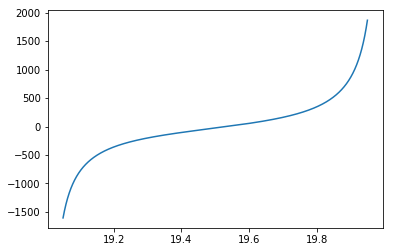

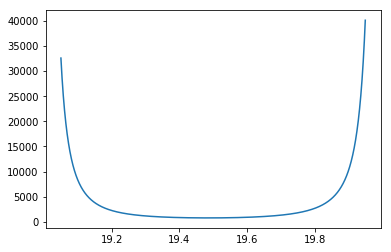

In [9]:
# Plot the functions between a[0] and a[1]
test_spectral = lambda x: spectral_func(a, b, gamma, x)

# Prime derivative
test_spectral_prime = lambda x: spectral_func_prime(a, b, x)

# Slight perturbation to avoid divergence on the plot
epsilon = 0.05
linspace = np.linspace(a[1] + epsilon, a[0] - epsilon, 10000)

# Compute the values and plot the original function
values = [test_spectral(x) for x in linspace]
plt.figure()
plt.plot(linspace, values)

# Compute the values and plot the derivative
values_prime = [test_spectral_prime(x) for x in linspace]
plt.figure()
plt.plot(linspace, values_prime)

# Show
plt.show()

In [10]:
def interior_sigma_coef(a, b, gamma, x, k):
    first_term = 3 * x - (gamma + a[k - 1] + a[k])
    to_sum1 = np.power(b, 2) / (a - x)
    to_sum2 = (a - a[k-1]) / (a - x)
    to_sum3 = (a - a[k]) / (a - x)
    return first_term + np.sum(to_sum1 * to_sum2 * to_sum3)

In [11]:
def interior_omega1_coef(a, b, gamma, x, k):
    a_reduced = np.delete(a, k - 1)
    b_reduced = np.delete(b, k - 1)
    to_sum1 = np.power(b_reduced, 2) / np.power(a_reduced - x, 2)
    to_sum2 = (a_reduced - a[k]) / (a_reduced - x)
    fac = np.power(a[k - 1] - x, 3) / (a[k - 1] - a[k])
    return b[k - 1] ** 2 + fac * (1 + np.sum(to_sum1 * to_sum2))

In [12]:
def interior_omega2_coef(a, b, gamma, x, k):
    a_reduced = np.delete(a, k)
    b_reduced = np.delete(b, k)
    to_sum1 = np.power(b_reduced, 2) / np.power(a_reduced - x, 2)
    to_sum2 = (a_reduced - a[k - 1]) / (a_reduced - x)
    fac = np.power(x - a[k], 3) / (a[k - 1] - a[k])
    return b[k] ** 2 + fac * (1 + np.sum(to_sum1 * to_sum2))

In [13]:
def rationnal_interpolation(a, b, gamma, x, y, k) : 
    sig = interior_omega1_coef(a, b, gamma, x, k)
    omega1 = interior_omega1_coef(a, b, gamma, x, k)
    omega2 = interior_omega2_coef(a, b, gamma, x, k)
    return sig + omega1 / (a[k-1] - y) + omega1 / (a[k] - y)

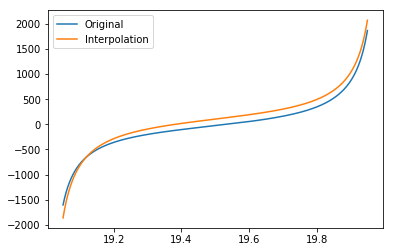

In [14]:
# Plot the rationnal interpolation between a[0] and a[1] in (a[0] + a[1]) / 2
x0 = (a[0] + a[1]) / 2

# Slight perturbation to avoid divergence on the plot
epsilon = 0.05
linspace = np.linspace(a[1] + epsilon, a[0] - epsilon, 1000)

# Rationnal interpolation
test_inter = lambda y: rationnal_interpolation(a, b, gamma, x0, y, 1)
values_inter = [test_inter(y) for y in linspace]

# Original function within the same bounds
test_spectral = lambda x: spectral_func(a, b, gamma, x)
values = [test_spectral(x) for x in linspace]

# Show
plt.plot(linspace, values, label="Original")
plt.plot(linspace, values_inter, label="Interpolation")
plt.legend()
plt.show()

In [15]:
def interior_alpha(a, b, gamma, x, k):
    sig = interior_sigma_coef(a, b, gamma, x, k)
    deno = (a[k - 1] - x) * (x - a[k])
    return sig / deno

In [16]:
def interior_beta(a, b, gamma, x, k):
    prime = spectral_func_prime(a, b, x)
    fac = (1 / (a[k - 1] - x)) + (1 / (a[k] - x))
    func = spectral_func(a, b, gamma, x)
    return prime - fac * func

In [18]:
# Verification for the result yielded by the program in cuda C:
x = np.zeros((n, ))
for i in range(1, n-1):
    x[i] = (a[i - 1] + a[i]) / 2
x[0] = a[0] + 5
x[n-1] = a[n-2] -5
print(x)
print([interior_sigma_coef(a, b, gamma, x[k], k) for k in range(1, n-1)])
print([interior_alpha(a, b, gamma, x[k], k) for k in range(1, n-1)])

[25.  19.5 18.5 17.5 16.5 15.5 14.5 13.5 12.5  7. ]
[-58.59713031772738, 21.154894609914255, 64.79196170503867, 88.16258391422411, 98.67444976344447, 100.50186944256433, 96.42851127756873, 88.61381235610536]
[-234.3885212709095, 84.61957843965702, 259.1678468201547, 352.65033565689646, 394.6977990537779, 402.0074777702573, 385.7140451102749, 354.4552494244214]


In [20]:
def interior_increment(a, b, gamma, x, k):
    f = spectral_func(a, b, gamma, x)
    beta = interior_beta(a, b, gamma, x, k)
    alpha = interior_alpha(a, b, gamma, x, k)
    term1 = 2 * f / beta
    term2 = 2 * alpha / beta
    deno = 1 + np.sqrt(1 + term1 * term2)
    return term1 / deno

In [37]:
def interior_zero_finder(a, b, gamma, x0, k, epsilon=0.0001, maxit=1000):
    i = 0
    dist = np.inf
    x = x0
    func_track = []
    x_track = []
    x_track.append(x0)
    func = spectral_func(a, b, gamma, x) 
    func_track.append(func)
    dist = func ** 2
    while (dist > epsilon) and (i < maxit):
        delta = interior_increment(a, b, gamma, x, k)
        x -= delta
        func = spectral_func(a, b, gamma, x) 
        dist = func ** 2
        func_track.append(func)
        x_track.append(x)
    return x, x_track, func_track

In [39]:
# Verification for the result yielded by the program in cuda C:
x = np.zeros((n, ))
for i in range(1, n-1):
    x[i] = (a[i - 1] + a[i]) / 2
x[0] = a[0] + 5
x[n-1] = a[n-2] -5
interior_zeros_list = []
for k in range(1, n-1):
    xopt, xtrack, functrack = interior_zero_finder(a, b, gamma, x[k], k)
    interior_zeros_list.append(xopt)
print(interior_zeros_list)

[19.534141662425302, 18.412100122600613, 17.32419376250485, 16.252151433710413, 15.18981925383949, 14.134600930693026, 13.085704273131357, 12.043937606099986]


In [28]:
x

19.534141662425302

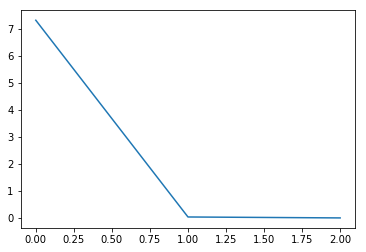

In [74]:
plt.plot(functrack)